### Introduction: 
This script builds a machine learning model to predict whether a patient has diabetes based on their symptoms and age. It uses a logistic regression algorithm, which is commonly used for binary classification problems (like yes/no or diabetic/non-diabetic). The model is trained on historical patient data and then tested to see how well it can predict diabetes in new patients.

In [65]:
# Import libraries for data handling, modeling, and evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [66]:
# Load dataset and clean column names for consistency
diabetes_processed = pd.read_csv("../data/processed/diabetes_data_encoded.csv")

diabetes_processed.columns = (
    diabetes_processed.columns
    .str.strip()            # Remove leading/trailing spaces
    .str.lower()            # Convert to lowercase
    .str.replace(' ', '_')  # Replace spaces with underscores
)

# Separate features(X) and target(y) variables
X = diabetes_processed.drop('diabetes', axis=1) #Features: symptoms and age
y = diabetes_processed['diabetes'] #Target: diabetes status (yes/no)

# Identify column types
categorical_features = ['gender', 'polyuria', 'polydipsia', 'sudden_weight_loss',
       'weakness', 'polyphagia', 'genital_thrush', 'visual_blurring',
       'itching', 'irritability', 'delayed_healing', 'partial_paresis',
       'muscle_stiffness', 'alopecia', 'obesity']  
numeric_features = ['age']         


In [67]:
# Define a preprocessing pipeline:
# - Standardize numeric features
# - One-hot encode categorical features

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),   
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' 
)


In [68]:
# Build a pipeline that applies preprocessing first, then logistic regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Split data into training and test sets (stratify keeps class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the model
pipeline.fit(X_train, y_train)

# Predict diabetes status and calculate prediction probabilities
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluate performance using AUC and a classification report
print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


AUC: 0.9906250000000001
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        40
           1       0.98      0.92      0.95        64

    accuracy                           0.94       104
   macro avg       0.93      0.95      0.94       104
weighted avg       0.95      0.94      0.94       104



### Logistic Regression Model Results and Insights
The logistic regression model demonstrates exceptional predictive performance for early-stage diabetes detection, achieving an AUC of 0.99, which indicates near-perfect discrimination between diabetic and non-diabetic patients. With an overall accuracy of 94%, the model correctly classifies the vast majority of cases.
Class-wise performance is strong:
- Non-diabetic patients (Class 0): 97% recall and 89% precision
- Diabetic patients (Class 1): 92% recall and 98% precision
This balance between precision and recall yields high F1-scores of 0.93 and 0.95, confirming the model’s reliability across both groups—even with a slight class imbalance.

In practical terms, the model minimizes both false positives and false negatives, making it highly suitable for clinical screening or digital health applications. It provides a robust baseline for further exploration.


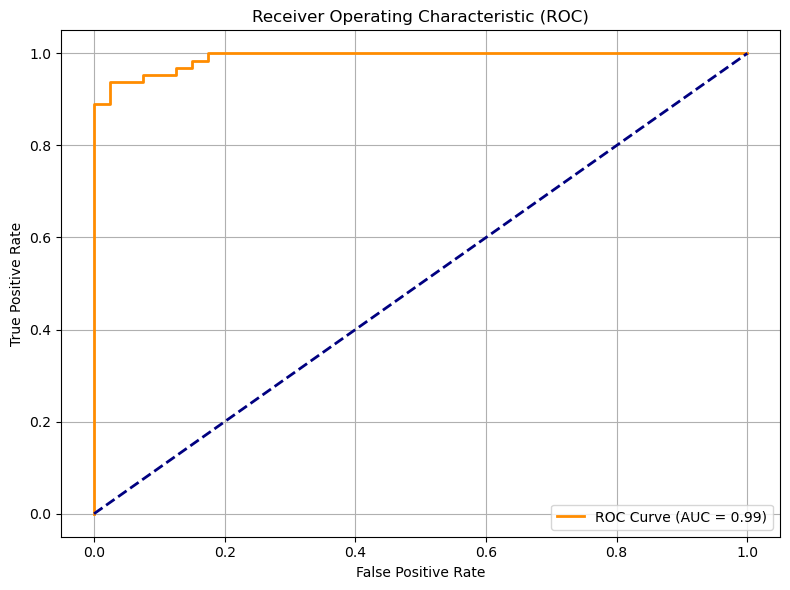

In [69]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### Evaluating Classification Accuracy with ROC Curve
The ROC curve (Receiver Operating Characteristic curve) is a visual tool that shows how well our model distinguishes between patients with and without diabetes. It plots the trade-off between the true positive rate (correctly identifying diabetic patients) and the false positive rate (incorrectly labeling non-diabetic patients as diabetic).

A curve that hugs the top-left corner, like ours, indicates excellent performance. The Area Under the Curve (AUC) is 0.99, meaning the model is nearly perfect at separating the two groups. This gives stakeholders confidence that the model is highly reliable for early-stage diabetes detection.


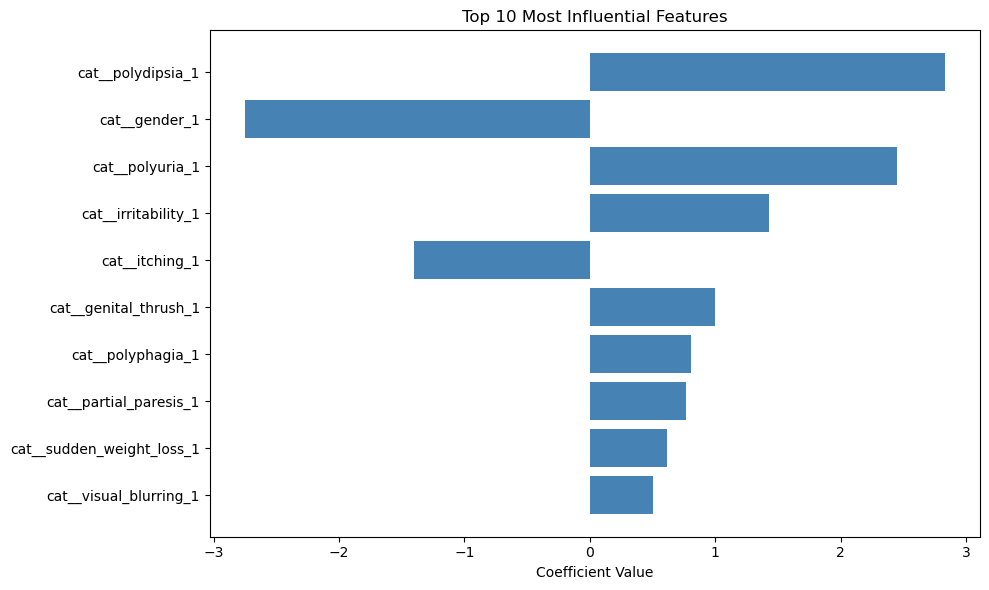

In [70]:
# Feature names after preprocessing
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Model coefficients
coefficients = pipeline.named_steps['classifier'].coef_[0]

# Create a DataFrame with feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Plot top 10 most influential features
top_features = feature_importance.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Top 10 Most Influential Features')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

### Feature Importance and Gender Insights

This chart highlights the top 10 features that most influence the model’s prediction of diabetes. Each bar represents how strongly a symptom or trait contributes to the decision:

- **Positive values** (bars pointing right) indicate features that increase the likelihood of being classified as diabetic.
- **Negative values** (bars pointing left) suggest features that reduce the likelihood.

For example, **polydipsia (excessive thirst)** has the strongest positive influence, meaning patients with this symptom are much more likely to be classified as diabetic. Conversely, **gender** shows a strong negative coefficient, indicating that it plays a significant role in how symptoms manifest or are interpreted by the model.

One of the most influential traits is **gender**, where being male (assuming male is encoded as 1) is associated with a lower likelihood of being classified as diabetic in this dataset. This doesn’t imply that men are less likely to have diabetes overall—it reflects how symptoms present differently across genders. For instance, symptoms like polydipsia or polyuria may be more predictive in women than in men, and the model adjusts its predictions based on these patterns.

Understanding these gender-based differences is essential for:
- **Tailoring screening strategies** to better reflect how symptoms appear in men vs. women.
- **Reducing bias** to ensure the model doesn’t over- or under-predict for either gender.
- **Designing future models** that include gender-symptom interaction terms to capture more nuanced relationships.

These insights support more personalized and equitable healthcare interventions. They also provide a strong foundation for future analysis, such as exploring how symptom importance shifts when we isolate male and female patients.

